# Training Models

In [3]:
# Reproducibility info
import os
os.environ['JUPYTER_IMAGE']

'pangeo/pytorch-notebook:2023.08.29'

In [1]:
import pandas as pd
import numpy as np
import xarray as xr

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

import gcsfs
fs = gcsfs.GCSFileSystem()
import os
import sys
import cftime
import time
from dask.diagnostics import ProgressBar

## Load Data 

In [2]:
from utils import load_vars_xarray, split_input_output, list_all_vars
# same variables as VED paper
# humidity, temp, solar insolation, latent and sensible heat, surface pressure
input_vars = 'state_q0001 state_t pbuf_SOLIN pbuf_LHFLX pbuf_SHFLX state_ps'.split()
output_vars = ['state_q0001', 'state_t', 'cam_out_NETSW', 'cam_out_FLWDS', 'cam_out_PRECC']
ds = load_vars_xarray(input_vars, output_vars, True, True)

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/dataset.py:255: UserWarning: The specified Dask chunks separate the stored chunks along dimension "sample" starting at index 720. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


Daily average


In [3]:
i, o = list_all_vars()
print(o)

['cam_out_FLWDS', 'cam_out_NETSW', 'cam_out_PRECC', 'cam_out_PRECSC', 'cam_out_SOLL', 'cam_out_SOLLD', 'cam_out_SOLS', 'cam_out_SOLSD', 'state_q0001', 'state_q0002', 'state_q0003', 'state_t', 'state_u', 'state_v']


In [4]:
ds

<xarray.Dataset>
Dimensions:            (time: 2920, lev: 60, ncol: 384)
Coordinates:
  * time               (time) object 0001-02-01 12:00:00 ... 0009-01-31 12:00:00
  * ncol               (ncol) int64 0 1 2 3 4 5 6 ... 378 379 380 381 382 383
    lat                (ncol) float64 -32.59 -35.99 -22.69 ... 45.34 45.34 40.39
    lon                (ncol) float64 -39.73 -28.47 -39.56 ... 123.3 146.7 135.0
Dimensions without coordinates: lev
Data variables:
    state_q0001        (time, lev, ncol) float64 dask.array<chunksize=(10, 60, 384), meta=np.ndarray>
    state_t            (time, lev, ncol) float64 dask.array<chunksize=(10, 60, 384), meta=np.ndarray>
    pbuf_SOLIN         (time, ncol) float64 dask.array<chunksize=(10, 384), meta=np.ndarray>
    pbuf_LHFLX         (time, ncol) float64 dask.array<chunksize=(10, 384), meta=np.ndarray>
    pbuf_SHFLX         (time, ncol) float64 dask.array<chunksize=(10, 384), meta=np.ndarray>
    state_ps           (time, ncol) float64 dask.array<chunksize=(10, 384), meta=np.ndarray>
    out_state_q0001    (time, lev, ncol) float64 dask.array<chunksize=(10, 60, 384), meta=np.ndarray>
    out_state_t        (time, lev, ncol) float64 dask.array<chunksize=(10, 60, 384), meta=np.ndarray>
    out_cam_out_NETSW  (time, ncol) float64 dask.array<chunksize=(10, 384), meta=np.ndarray>
    out_cam_out_FLWDS  (time, ncol) float64 dask.array<chunksize=(10, 384), meta=np.ndarray>
    out_cam_out_PRECC  (time, ncol) float64 dask.array<chunksize=(10, 384), meta=np.ndarray>
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

In [5]:
def select_region(ds, condition):
    # assumes condition is a lambda function taking in a lat and lon
    # returns the indices for which this is true
    lat, lon = ds.lat.values, ds.lon.values
    latlon = pd.DataFrame({"lat" : lat, "lon": lon})
    return(list(latlon[latlon.apply(condition, axis=1)].index)) # the indices of the matching latlons

def split_ds_by_area(ds, condition):
    match = select_region(ds, condition)
    unmatch = select_region(ds, lambda row : not condition(row))
    return(ds.isel(ncol=match), ds.isel(ncol=unmatch))

### Process and Load Dataset

In [6]:
selected_levels = np.append(np.linspace(4, 24, 6), np.linspace(26, 59, 14)).astype(np.int32)
ds = ds.isel(lev=selected_levels)
selected_levels

array([ 4,  8, 12, 16, 20, 24, 26, 28, 31, 33, 36, 38, 41, 43, 46, 48, 51,
       53, 56, 59], dtype=int32)

In [7]:
ds = ds.isel(time = slice(0, 4*365), ncol=slice(0, 16))

In [8]:
ds.time.size * ds.ncol.size

23360

In [9]:
with ProgressBar():
    ds.load()

[########################################] | 100% Completed | 11m 3ss


In [12]:
ds

<xarray.Dataset>
Dimensions:            (time: 1460, lev: 20, ncol: 16)
Coordinates:
  * time               (time) object 0001-02-01 12:00:00 ... 0005-01-31 12:00:00
  * ncol               (ncol) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
    lat                (ncol) float64 -32.59 -35.99 -22.69 ... -25.37 -22.69
    lon                (ncol) float64 -39.73 -28.47 -39.56 ... 39.73 28.31 39.56
Dimensions without coordinates: lev
Data variables:
    state_q0001        (time, lev, ncol) float64 1.424e-06 1.455e-06 ... 0.01655
    state_t            (time, lev, ncol) float64 257.8 258.9 ... 301.3 299.2
    pbuf_SOLIN         (time, ncol) float64 477.9 475.6 476.4 ... 479.3 477.5
    pbuf_LHFLX         (time, ncol) float64 77.19 113.1 184.8 ... 16.02 157.0
    pbuf_SHFLX         (time, ncol) float64 3.864 9.653 51.89 ... 126.7 21.06
    state_ps           (time, ncol) float64 1.011e+05 1.013e+05 ... 9.759e+04
    out_state_q0001    (time, lev, ncol) float64 1.424e-06 1.455e-06 ... 0.01653
    out_state_t        (time, lev, ncol) float64 257.8 258.9 ... 301.1 299.2
    out_cam_out_NETSW  (time, ncol) float64 332.9 313.0 243.3 ... 259.3 268.9
    out_cam_out_FLWDS  (time, ncol) float64 354.8 339.1 399.6 ... 407.3 419.9
    out_cam_out_PRECC  (time, ncol) float64 2.325e-11 1.05e-09 ... 1.685e-08
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

In [13]:
def normalize(xarr):
    var_means = xarr.mean(dim=['time', 'ncol']) # spatiotemporal mean
    var_stds = xarr.std(dim=['time', 'ncol']) # spatiotemporal meana
    arr = (xarr - var_means) / var_stds
    
    means = []
    stds = []
    for var in arr.data_vars:
        means.append(var_means[var].values.reshape(-1, 1))
        stds.append(var_stds[var].values.reshape(-1, 1))
    return(arr, np.vstack(means)[:, 0], np.vstack(stds)[:,0])

In [14]:
ds_norm, ds_mu, ds_sigma = normalize(ds)

In [201]:
train = ds_norm.isel(time = slice(0, 3 * 365 + 1), ncol=slice(0,16))
test = ds_norm.isel(time = slice(3*365 + 1, 4*365), ncol=slice(0, 16))

In [202]:
X_train_xarr, Y_train_xarr = split_input_output(train)
X_test_xarr, Y_test_xarr = split_input_output(test)

In [203]:
X_train_np = X_train_xarr.to_stacked_array("v", sample_dims=["ncol", 'time']).values.reshape(-1, 44)
Y_train_np = Y_train_xarr.to_stacked_array("v", sample_dims=["ncol", 'time']).values.reshape(-1, 43)

X_test_np = X_test_xarr.to_stacked_array("v", sample_dims=["ncol", 'time']).values.reshape(-1, 44)
Y_test_np = Y_test_xarr.to_stacked_array("v", sample_dims=["ncol", 'time']).values.reshape(-1, 43)

In [204]:
print(X_train_np.shape)
print(Y_train_np.shape)

print(X_test_np.shape)
print(Y_test_np.shape)

(17536, 44)
(17536, 43)
(5824, 44)
(5824, 43)


In [18]:
#train = ds.isel(ncol=select_region(ds, lambda row : abs(row.lat) < 30))
#test = ds.isel(ncol=select_region(ds, lambda row : 30 < abs(row.lat) < 60))

## Dataloader

In [191]:
device = "cuda" if torch.cuda.is_available() else "cpu" 

In [303]:
class MyDataset(Dataset):
    def __init__(self, ds, device = "cuda" if torch.cuda.is_available() else "cpu"):
        self.ds = ds
        self.X_ds, self.Y_ds = split_input_output(ds)
        self.device = device
        
        self.X_norm, self.X_mean, self.X_std = normalize(self.X_ds)
        self.Y_norm, self.Y_mean, self.Y_std = normalize(self.Y_ds)
        
    def __len__(self):
        return( self.ds.time.size * self.ds.ncol.size )
    
    def __getitem__(self, idx):
        t, col = idx // self.ds.ncol.size, idx % self.ds.ncol.size
        X = self.X_norm.isel(time=t, ncol=[col])
        Y = self.Y_norm.isel(time=t, ncol=[col])
        
        X = X.to_stacked_array("v", sample_dims=["ncol"]).values
        Y = Y.to_stacked_array("v", sample_dims=["ncol"]).values
        
        X = torch.as_tensor(X, device=self.device, dtype=torch.float32)
        Y = torch.as_tensor(Y, device=self.device, dtype=torch.float32)
        return(X.flatten(), Y.flatten())

In [206]:
%%time
dataset = MyDataset(train, device)
x, y = dataset[0]

CPU times: user 81.1 ms, sys: 9 ms, total: 90.1 ms
Wall time: 89.3 ms


In [27]:
y.shape

torch.Size([43])

In [33]:
batch_sizes = [1, 2, 4, 8, 16, 32, 64, 128, 512]
times = []
for size in batch_sizes:
    start = time.time()
    dl = DataLoader(dataset, batch_size=size, shuffle=True)
    x, y = next(iter(dl))
    times.append(time.time() - start) 
    print(f"{x.shape}, {y.shape}, took {time.time() - start} seconds \n")

torch.Size([1, 44]), torch.Size([1, 43]), took 0.05240154266357422 seconds 

torch.Size([2, 44]), torch.Size([2, 43]), took 0.0874016284942627 seconds 

torch.Size([4, 44]), torch.Size([4, 43]), took 0.17470192909240723 seconds 

torch.Size([8, 44]), torch.Size([8, 43]), took 0.3521735668182373 seconds 

torch.Size([16, 44]), torch.Size([16, 43]), took 0.6709597110748291 seconds 

torch.Size([32, 44]), torch.Size([32, 43]), took 1.3588073253631592 seconds 

torch.Size([64, 44]), torch.Size([64, 43]), took 2.727426528930664 seconds 

torch.Size([128, 44]), torch.Size([128, 43]), took 5.3670127391815186 seconds 

torch.Size([512, 44]), torch.Size([512, 43]), took 21.648482084274292 seconds 



In [40]:
times_toy_ds = [0.017, 0.02973, 0.0584, 0.12579, 0.2341, 0.4631, 0.899, 1.795, 7.21] # copied from DataProcessing
# Loading a sample takes almost 3x longer than toy dataset

In [85]:
i = 5
print(f"with batch size of {batch_sizes[i]}, ought to take {times[i]} x  {len(dataset) / batch_sizes[i]} = {times[i] * len(dataset) / batch_sizes[i]} seconds per epoch")

with batch size of 32, ought to take 1.3587939739227295 x  547.5 = 743.9397007226944 seconds per epoch


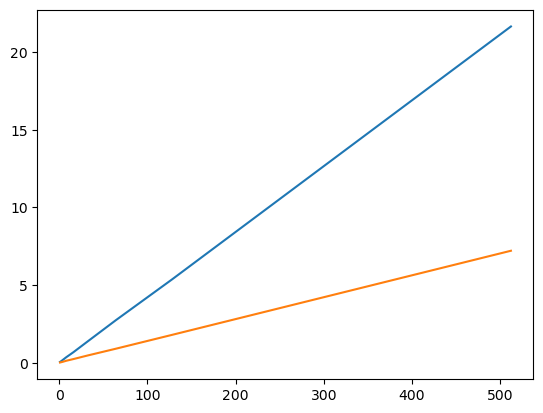

In [46]:
plt.plot(batch_sizes, times)
plt.plot(batch_sizes, times_toy_ds)

### Exploratory Data Analysis

In [29]:
#ds['lon'] = (ds.lon + 180) % 360 - 180
select_region(ds, lambda row : (abs(row.lon - -73) < 5 and abs(row.lat-40) < 2)) # selecting specific latlon
ny_col = select_region(ds, lambda row : (abs(row.lon - -73) < 5 and abs(row.lat-40) < 2))
ny_col # new york

[251]

In [ ]:
ds.where(ds.isnull()).sum() # no Nan Values

In [ ]:
plt.plot(ds.state_q0001.isel(time=20, ncol=15), label='full')
plt.plot(selected_levels, toy.state_q0001.isel(time=20, ncol=15), label='reduced_levels')
plt.legend()
plt.show()

In [ ]:
X, Y = split_input_output(train)
plt.plot(((X - X.mean(dim=['time', 'ncol'])) / X.std(dim)))

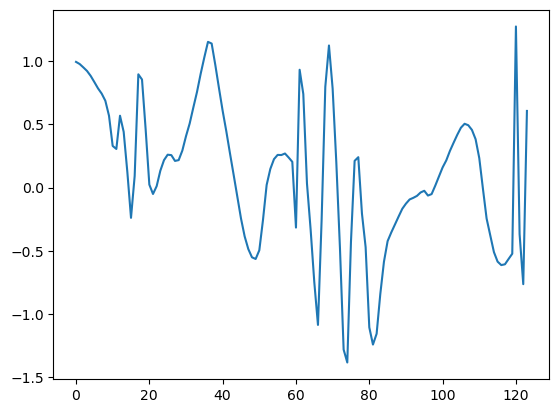

In [42]:
plt.plot(X_sample[1, :].cpu())

In [30]:
%%time
i = 10
X_norm, Y_norm = dataset[i]
print(X_norm.shape, Y_norm.shape, '\n')
plt.plot(Y_norm.cpu().numpy())
plt.show()

NameError: name 'dataset' is not defined

## Define Model

In [19]:
class VariationalEncoder(torch.nn.Module):
    """
    Conditional VAE Encoder with <layers>+1 fully connected layer
    """
    def __init__(self, in_dims, hidden_dims=[128, 128, 64, 32], latent_dims=5, layers=4, dropout=0, device='cuda'):
        super().__init__()
        self.linears = [torch.nn.Sequential(
                torch.nn.Linear(in_dims, hidden_dims[0]),
                torch.nn.LayerNorm(hidden_dims[0]),
                torch.nn.Dropout(p=dropout))]
        self.add_module('linear0', self.linears[-1])
        for i in range(1, layers):
            self.linears += [torch.nn.Sequential(
                torch.nn.Linear(hidden_dims[i-1], hidden_dims[i]),
                torch.nn.LayerNorm(hidden_dims[i]),
                torch.nn.Dropout(p=dropout))
                ]
            self.add_module('linear%d' % i, self.linears[-1])
        self.linear_mean = torch.nn.Linear(hidden_dims[-1], latent_dims)
        self.linear_logstd = torch.nn.Linear(hidden_dims[-1], latent_dims) # log of actual, later exponentiate

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device)
        self.N.scale = self.N.scale.to(device)
        self.kl = 0
        
        self.device = device
        
    def forward(self, x, return_latent=False):
        if(len(x.shape) > 1):
            x = torch.flatten(x, start_dim=1)
        for linear in self.linears:
            x = torch.nn.functional.relu(linear(x))
        mu = self.linear_mean(x) # mu is g(l(x))
        if return_latent:
            return mu
        else:
            sigma = torch.exp(self.linear_logstd(x)) # sigma is h(l(x))
            z = mu + sigma * self.N.sample(mu.shape) # reparameterization trick
            self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).mean()
            return z



In [20]:
class Decoder(torch.nn.Module):
    """
    Conditional VAE Decoder with <layers>+1 fully connected layer
    """
    def __init__(self, out_dims, hidden_dims=[32, 64, 128, 128], latent_dims=3, layers=4, dropout=0):
        super().__init__()
        self.linears = [torch.nn.Sequential(
                torch.nn.Linear(latent_dims, hidden_dims[0]),
                torch.nn.LayerNorm(hidden_dims[0]),
                torch.nn.Dropout(p=dropout))]
        self.add_module('linear0', self.linears[-1])
        
        for i in range(1, layers):
            self.linears += [torch.nn.Sequential(
                torch.nn.Linear(hidden_dims[i-1], hidden_dims[i]),
                torch.nn.LayerNorm(hidden_dims[i]),
                torch.nn.Dropout(p=dropout))
                ]
            self.add_module('linear%d' % i, self.linears[-1])        

        self.final_linear1 = torch.nn.Linear(hidden_dims[-1], out_dims)
        # self.final_linear2 = torch.nn.Linear(hidden_dims, out_dims)
        self.final_log_std1 = torch.nn.Linear(hidden_dims[-1], out_dims)
        # self.final_log_std2 = torch.nn.Linear(hidden_dims, out_dims)
        # self.final_lambda = torch.nn.Linear(hidden_dims, 1)
        # self.final_prob_zero = torch.nn.Linear(hidden_dims, out_dims)

    def forward(self, z): # outputs distribution
        for linear in self.linears:
            z = torch.nn.functional.relu(linear(z))
        m1 = self.final_linear1(z)
        # m2 = self.final_linear2(z)
        s1 = torch.exp(self.final_log_std1(z))
        # s2 = torch.exp(self.final_std2(z))
        # lam = self.final_lambda
        # p0 = torch.sigmoid(self.final_prob_zero(z))
        return m1, s1

In [21]:
class VariationalEncoderDecoder(torch.nn.Module):
    def __init__(self, model_params):
        super().__init__()
        self.data_dims = model_params['data_dims']
        self.label_dims = model_params['label_dims']
        self.latent_dims = model_params['latent_dims']
        self.device = model_params['device']
        dropout = model_params['dropout']

        # Encoder - compresses data into latent dims
        self.encoder = VariationalEncoder(self.data_dims, model_params['input_layers'], self.latent_dims, 
                       len(model_params['input_layers']), dropout).to(self.device)

        # Decoder - tries to learn both input and output variables. 
        self.decoder = Decoder(self.label_dims + self.data_dims, model_params['output_layers'], self.latent_dims, 
                               layers=len(model_params['output_layers']), dropout=dropout).to(self.device)
        self.beta = model_params['beta']
        
        self.losses = []

    def forward(self, x, return_latent=False):
        # expect to be batch_size x data_dims matrix and y to be batch_size x label_dims matrix
        
        z = self.encoder(x, return_latent)
        if return_latent:
            return z
        O_hat_mu, O_hat_std = self.decoder(z)
        return O_hat_mu, O_hat_std

# Train and Evaluate Models

## Toy Baseline Model

In [65]:
device= 'cuda'

In [68]:
class ToyModel(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = torch.nn.Linear(input_size, output_size, bias=True)
    
    def forward(self, x):
        return(self.linear(x))
    
    def trainer(self, num_epochs, dataloader, lr=0.001):
        self.train()
        optim = torch.optim.SGD(self.parameters(), lr=lr)
        losses = []
        for epoch in range(num_epochs):
            batch_times = []
            backprop_times = []
            start = time.time()
            for batch, (X, y) in enumerate(dataloader):
                batch_time = time.time()
                batch_times.append(batch_time - start)
                pred = self(X)
                loss = (pred - y)**2
                loss.sum().backward()
                optim.step()
                optim.zero_grad()
                backprop_times.append(time.time() - batch_time)
                losses.append(loss.mean().item())
                start = time.time()
            print(f"Epoch : {epoch}; avg batching={np.mean(batch_times)}; avg backprop={np.mean(backprop_times)}")   
                
        return(losses)

In [69]:
x, y = toy_dataset[0]
x.shape[0]

40

In [70]:
toy_model = ToyModel(x.shape[-1], y.shape[-1]).to('cuda')
toy_model

ToyModel(
  (linear): Linear(in_features=40, out_features=1, bias=True)
)

In [71]:
%%time
num_epochs = 3
losses = toy_model.trainer(num_epochs, toy_dataloader)

Epoch : 0; avg batching=0.4290027201501398; avg backprop=0.00088462933816545
Epoch : 1; avg batching=0.425509659970393; avg backprop=0.0008596058100299106
Epoch : 2; avg batching=0.43084282041247424; avg backprop=0.0008982387396807228
CPU times: user 3min 54s, sys: 1.31 s, total: 3min 55s
Wall time: 3min 55s


[2.386765241622925,
 1.8761513233184814,
 0.8051239252090454,
 0.41617944836616516,
 0.6716220378875732,
 0.8658982515335083,
 0.6051923036575317,
 1.2757468223571777,
 0.2988331913948059,
 0.36122995615005493,
 0.3121259808540344,
 1.1467030048370361,
 0.9178881645202637,
 0.4954041540622711,
 0.2358592003583908,
 0.40547919273376465,
 0.278512179851532,
 0.45687851309776306,
 0.4017557203769684,
 0.4028594493865967,
 0.3644106984138489,
 0.6063108444213867,
 0.6837299466133118,
 1.4608982801437378,
 0.7247801423072815,
 0.4431780278682709,
 0.22989657521247864,
 1.0222480297088623,
 1.584335207939148,
 0.7772551774978638,
 1.3758747577667236,
 1.6957783699035645,
 0.9273055791854858,
 2.071084976196289,
 1.6002326011657715,
 1.5584895610809326,
 1.6363437175750732,
 0.5316412448883057,
 0.2802412509918213,
 2.3738200664520264,
 2.2056779861450195,
 1.5232465267181396,
 1.8080880641937256,
 1.4014312028884888,
 0.3552132844924927,
 0.2967804968357086,
 0.26800602674484253,
 0.14889506

In [108]:
len(toy_dataloader) * 0.44 * num_epochs / 60 # explanation of time

13.383333333333333

In [72]:
# Save Toy Model
baseDir = '/home/jovyan/Samarth/Main/saved_data/'
toy_model_path = os.path.join(baseDir, 'models/toy_model1.pt')

torch.save(toy_model.state_dict(), toy_model_path)

## Actual Model

In [104]:
#from Architectures.VED import VariationalEncoderDecoder

In [29]:
x, y = dataset[0]
len(y)

43

In [94]:
model_params = {'beta': 0.05,
    'data_dims': 44,
    'label_dims': 43,
    'latent_dims': 6,
    'input_layers': [32, 16],
    'output_layers': [16, 32],
    'dropout': 0.05,
    'device' : 'cuda' if torch.cuda.is_available() else 'cpu',
    'architecture': 'ved'}
                

In [402]:
VED = VariationalEncoderDecoder(model_params)
VED

VariationalEncoderDecoder(
  (encoder): VariationalEncoder(
    (linear0): Sequential(
      (0): Linear(in_features=44, out_features=32, bias=True)
      (1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (2): Dropout(p=0.05, inplace=False)
    )
    (linear1): Sequential(
      (0): Linear(in_features=32, out_features=16, bias=True)
      (1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (2): Dropout(p=0.05, inplace=False)
    )
    (linear_mean): Linear(in_features=16, out_features=6, bias=True)
    (linear_logstd): Linear(in_features=16, out_features=6, bias=True)
  )
  (decoder): Decoder(
    (linear0): Sequential(
      (0): Linear(in_features=6, out_features=16, bias=True)
      (1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (2): Dropout(p=0.05, inplace=False)
    )
    (linear1): Sequential(
      (0): Linear(in_features=16, out_features=32, bias=True)
      (1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (2): Dropout(

In [32]:
def get_num_parameters(model, show=False):
    p = iter(model.parameters())
    num = 0
    for param in p:
        ps = 1
        for i in param.shape:
            ps = ps * i
        if show:
            print(param.shape, ps)
        num = num + ps
    return(num)
get_num_parameters(VED, False)

8762

In [97]:
train_params = {'epochs': 15,
 'loss_type': 'mse',
 'optimizer': 'sgd',
 'lr': 0.004,
 'weight_decay': 0,
 'batch_size': 32}

In [98]:
save_params = {
    'name' : 'VED_trial3_npy', # RMB
    'plot' : False,
    'save' : True,
    'model_path' : "/home/jovyan/Samarth/Main/saved_data/models", 
    'savefig' : False,
    'save_interval' : 500,
    'figure_path' : '/home/jovyan/Samarth/Main/saved_data/figures',
    'filetype' : '.pt',
}

In [100]:
%%time
np.random.shuffle(X_train_np)

CPU times: user 21.2 ms, sys: 609 µs, total: 21.8 ms
Wall time: 21.6 ms


In [404]:
def train_model(model, train_params, save_params):

    # Training parameters
    if train_params['optimizer'] == 'adam':
        opt = torch.optim.Adam(model.parameters(), lr=train_params['lr'], weight_decay=train_params['weight_decay'])
    elif train_params['optimizer'] == 'sgd':
        opt = torch.optim.SGD(model.parameters(), lr=train_params['lr'], weight_decay=train_params['weight_decay'])
    else:
        raise ValueError('Unknown optimizer')
    opt.zero_grad()
    
    loss_fn = nn.MSELoss()
    
    batches_per_epoch = int(len(DataLoader(dataset, batch_size=train_params['batch_size'])))
    
    path = os.path.join(save_params['model_path'], save_params['name']) + save_params['filetype'] # checkpoint 
    text = 'Training '
    start = time.time()
    last = start
    last_timed = start

    losses = []
    KL_div = []
    for epoch in range(train_params['epochs']):
        np.random.shuffle(X_train_np)
        np.random.shuffle(Y_train_np)
        for batch in range(batches_per_epoch):
            now = time.time()
            x = X_train_np[train_params['batch_size'] * batch: train_params['batch_size'] * (batch + 1), :]
            y = Y_train_np[train_params['batch_size'] * batch: train_params['batch_size'] * (batch + 1), :]
            x = torch.tensor(x, device=device, dtype=torch.float32)
            y = torch.tensor(y, device=device, dtype=torch.float32)
            O_real = torch.cat([x, y], 1).to(model.device) # actual output desired 

            O_hat, O_std = model(x)

            # loss = ((y - y_hat) ** 2).sum() / self.label_dims + self.beta * self.encoder.kl / self.latent_dims
            mse = loss_fn(O_real, O_hat) #+ torch.log(O_std)
            loss = mse + model.beta * model.encoder.kl
            #loss = (0.5 * (y - y_mean) ** 2 / y_std + torch.log(y_std)).mean() + self.beta * self.encoder.kl

            #torch.clip(loss, min=-1e5, max=1e5).backward() # backpropagate loss
            if batch == 0 or batch == batches_per_epoch - 1 or now - last > 0.5: # print time status updates
                last = now
                perc = (epoch * batches_per_epoch + batch + 1) / (train_params['epochs'] * batches_per_epoch)
                inv_perc = (train_params['epochs'] * batches_per_epoch) / (epoch * batches_per_epoch + batch + 0.1)
                sys.stdout.write("\r%s[%.1f %%] - %d / %d (%d / %d) - %.1fs [TBD: %.1fs]" %
                                 (text, 100 * perc, epoch + 1, train_params['epochs'], batch + 1, batches_per_epoch,
                                  now - start, (now - start) * (inv_perc - 1)))
                sys.stdout.flush()
            if save_params['save'] and now - last_timed > save_params['save_interval']:
                torch.save(model.state_dict(), path)
                last_timed = now
            
            if(batch % 250 == 0):
                KL_div.append(model.encoder.kl.item())
                losses.append(mse.item()) 
            loss.backward()
            opt.step()
            opt.zero_grad() # VERY IMPORTANT! Reset gradients. 

    print('Last-epoch loss: %.2f' % (sum(losses[-batches_per_epoch:-1]) / batches_per_epoch))
    print('Finished Training')

    return(model, {"losses" : losses, "KL" : KL_div})

In [407]:
VED, info2 = train_model(VED, train_params, save_params)

Training [100.0 %] - 15 / 15 (548 / 548) - 25.0s [TBD: 0.0s]Last-epoch loss: 0.03
Finished Training


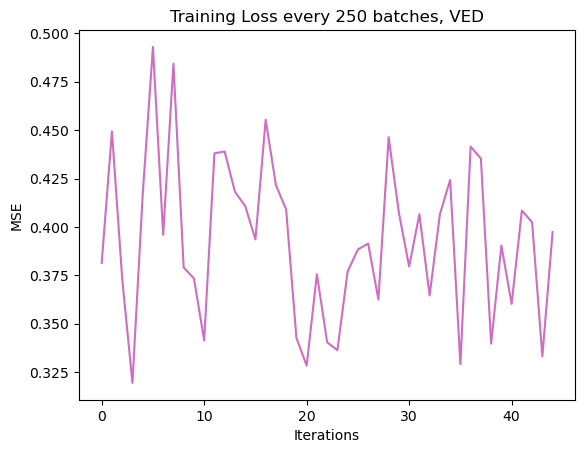

In [408]:
plt.plot(info2['losses'], color=(180/255, 24/255, 156/255), alpha=0.63)
plt.title('Training Loss every 250 batches, VED')
plt.xlabel("Iterations")
plt.ylabel("MSE")           
plt.show()

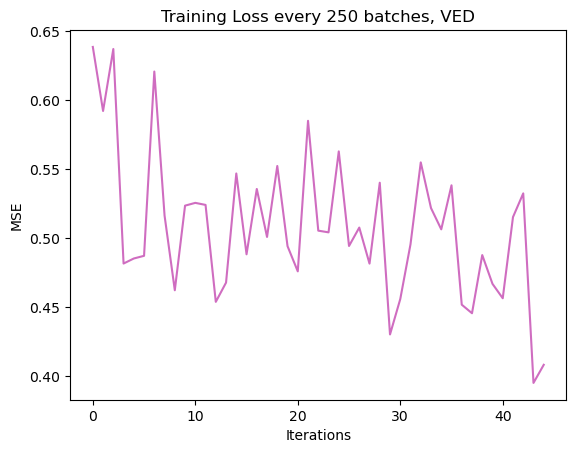

In [363]:
plt.plot(info['losses'], color=(180/255, 24/255, 156/255), alpha=0.63)
plt.title('Training Loss every 250 batches, VED')
plt.xlabel("Iterations")
plt.ylabel("MSE")           
plt.show()

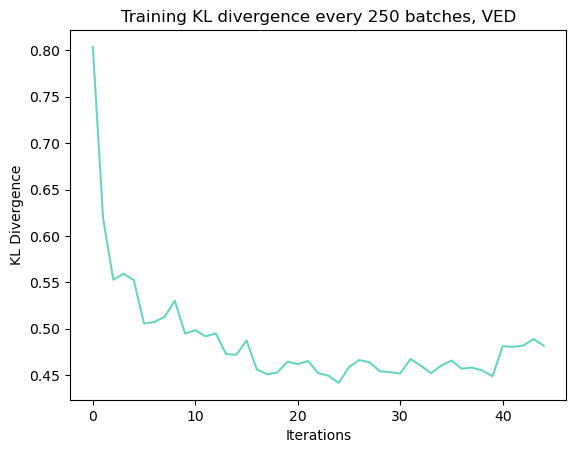

In [362]:
plt.plot(info['KL'], color=(18/255, 188/255, 156/255), alpha=0.63)
plt.title('Training KL divergence every 250 batches, VED')
plt.xlabel("Iterations")
plt.ylabel("KL Divergence")
plt.show()

In [366]:
save_params

{'name': 'VED_trial3_npy',
 'plot': False,
 'save': True,
 'model_path': '/home/jovyan/Samarth/Main/saved_data/models',
 'savefig': False,
 'save_interval': 500,
 'figure_path': '/home/jovyan/Samarth/Main/saved_data/figures',
 'filetype': '.pt'}

In [367]:
import json
def save_model(model):
    path = os.path.join(save_params['model_path'], save_params['name'])
    torch.save(model.state_dict(), path + save_params['filetype'])
    
    params = {
        'training_parameters' : train_params, 
        'model_parameters' : model_params, 
        'save_parameters' : save_params,
        'info' : info,
    }
    
    with open(path + ".json", 'w', encoding='utf-8') as f:
        json.dump(params, f, ensure_ascii=False, indent=4) 
    return(path)

In [368]:
save_model(model)

'/home/jovyan/Samarth/Main/saved_data/models/VED_trial3_npy'

In [369]:
m2 = load_model("VED_trial3_npy", baseDir)[0]
m2.load_state_dict(torch.load('/home/jovyan/Samarth/Main/saved_data/models/VED_t2.pt'))

<All keys matched successfully>

# Evaluating results

In [ ]:
pwd

'/home/jovyan/Samarth/Pipelines'

In [112]:
baseDir = '/home/jovyan/Samarth/Main/saved_data/models'

In [60]:
model_params

{'beta': 0.05,
 'data_dims': 44,
 'label_dims': 43,
 'latent_dims': 6,
 'input_layers': [32, 16],
 'output_layers': [16, 32],
 'dropout': 0.05,
 'device': 'cuda',
 'architecture': 'ved'}

In [111]:
import json
def load_model(name, baseDir = 'saved_data/models', load_params=True):
    path = os.path.join(baseDir, name)
    params = json.load(open(path + '.json'))
    model_params = params['model_parameters']
    architecture = model_params['architecture']
    match architecture.lower():
        case "ved":
            model = VariationalEncoderDecoder(model_params)
        case "vae":
            print("VAE loading not implemented")
        case "cvae":
            model = ConditionalVAE(model_params['beta'], model_params['data_dims'], model_params['label_dims'], dropout=model_params['dropout'],
                 latent_dims=model_params['latent_dims'], hidden_dims=model_params['hidden_dims'], layers=model_params['layers']).to(model_params['device'])
        case _:
            print("Unknown architecture")
    if(load_params): # load not just architecture but weights. Do unless training went terribly
        model.load_state_dict(torch.load(path + params['save_parameters']['filetype']))
    model.eval()

    return(model, params['training_parameters'])

In [306]:
VED, train_params = load_model('VED_trial3_npy', baseDir, True)

In [307]:
VED

VariationalEncoderDecoder(
  (encoder): VariationalEncoder(
    (linear0): Sequential(
      (0): Linear(in_features=44, out_features=32, bias=True)
      (1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (2): Dropout(p=0.05, inplace=False)
    )
    (linear1): Sequential(
      (0): Linear(in_features=32, out_features=16, bias=True)
      (1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (2): Dropout(p=0.05, inplace=False)
    )
    (linear_mean): Linear(in_features=16, out_features=6, bias=True)
    (linear_logstd): Linear(in_features=16, out_features=6, bias=True)
  )
  (decoder): Decoder(
    (linear0): Sequential(
      (0): Linear(in_features=6, out_features=16, bias=True)
      (1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (2): Dropout(p=0.05, inplace=False)
    )
    (linear1): Sequential(
      (0): Linear(in_features=16, out_features=32, bias=True)
      (1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (2): Dropout(

In [119]:
baseDir = '/home/jovyan/Samarth/Main/saved_data/models/'

In [311]:
ds

<xarray.Dataset>
Dimensions:            (time: 1460, lev: 20, ncol: 16)
Coordinates:
  * time               (time) object 0001-02-01 12:00:00 ... 0005-01-31 12:00:00
  * ncol               (ncol) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
    lat                (ncol) float64 -32.59 -35.99 -22.69 ... -25.37 -22.69
    lon                (ncol) float64 -39.73 -28.47 -39.56 ... 39.73 28.31 39.56
Dimensions without coordinates: lev
Data variables:
    state_q0001        (time, lev, ncol) float64 1.424e-06 1.455e-06 ... 0.01655
    state_t            (time, lev, ncol) float64 257.8 258.9 ... 301.3 299.2
    pbuf_SOLIN         (time, ncol) float64 477.9 475.6 476.4 ... 479.3 477.5
    pbuf_LHFLX         (time, ncol) float64 77.19 113.1 184.8 ... 16.02 157.0
    pbuf_SHFLX         (time, ncol) float64 3.864 9.653 51.89 ... 126.7 21.06
    state_ps           (time, ncol) float64 1.011e+05 1.013e+05 ... 9.759e+04
    out_state_q0001    (time, lev, ncol) float64 1.424e-06 1.455e-06 ... 0.01653
    out_state_t        (time, lev, ncol) float64 257.8 258.9 ... 301.1 299.2
    out_cam_out_NETSW  (time, ncol) float64 332.9 313.0 243.3 ... 259.3 268.9
    out_cam_out_FLWDS  (time, ncol) float64 354.8 339.1 399.6 ... 407.3 419.9
    out_cam_out_PRECC  (time, ncol) float64 2.325e-11 1.05e-09 ... 1.685e-08
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

In [378]:
def normalize(xarr):
    var_means = xarr.mean(dim=['time', 'ncol']) # spatiotemporal mean
    var_stds = xarr.std(dim=['time', 'ncol']) # spatiotemporal meana
    arr = (xarr - var_means) / var_stds
    
    means = []
    stds = []
    for var in arr.data_vars:
        means.append(var_means[var].values.reshape(-1, 1))
        stds.append(var_stds[var].values.reshape(-1, 1))
    return(arr, np.vstack(means)[:, 0], np.vstack(stds)[:,0])

In [302]:
ds_norm, ds_mu, ds_sigma = normalize(ds)
train = ds_norm.isel(time = slice(0, 3 * 365 + 1), ncol=slice(0,16))
test = ds_norm.isel(time = slice(3*365 + 1, 4*365), ncol=slice(0, 16))
X_train_xarr, Y_train_xarr = split_input_output(train)
X_test_xarr, Y_test_xarr = split_input_output(test)

X_train_np = X_train_xarr.to_stacked_array("v", sample_dims=["ncol", 'time']).values.reshape(-1, 44)
Y_train_np = Y_train_xarr.to_stacked_array("v", sample_dims=["ncol", 'time']).values.reshape(-1, 43)
X_test_np = X_test_xarr.to_stacked_array("v", sample_dims=["ncol", 'time']).values.reshape(-1, 44)
Y_test_np = Y_test_xarr.to_stacked_array("v", sample_dims=["ncol", 'time']).values.reshape(-1, 43)

In [304]:
class MyDataset(Dataset):
    def __init__(self, ds, device = "cuda" if torch.cuda.is_available() else "cpu"):
        self.ds = ds
        self.X_ds, self.Y_ds = split_input_output(ds)
        self.device = device
        
        self.X_norm, self.X_mean, self.X_std = normalize(self.X_ds)
        self.Y_norm, self.Y_mean, self.Y_std = normalize(self.Y_ds)
        
    def __len__(self):
        return( self.ds.time.size * self.ds.ncol.size )
    
    def __getitem__(self, idx):
        t, col = idx // self.ds.ncol.size, idx % self.ds.ncol.size
        X = self.X_norm.isel(time=t, ncol=[col])
        Y = self.Y_norm.isel(time=t, ncol=[col])
        
        X = X.to_stacked_array("v", sample_dims=["ncol"]).values
        Y = Y.to_stacked_array("v", sample_dims=["ncol"]).values
        
        X = torch.as_tensor(X, device=self.device, dtype=torch.float32)
        Y = torch.as_tensor(Y, device=self.device, dtype=torch.float32)
        return(X.flatten(), Y.flatten())

In [305]:
train_dataset = MyDataset(train)
test_dataset = MyDataset(test)

### Baseline Models

In [232]:
class LinearModel(nn.Module):
    def __init__(self, insize=44, outsize=43):
        super(LinearModel, self).__init__()
        # set hyperparameters
        n_neuron       = 32
        N_layers       = 1 # number of hidden layers
        
        self.linears = torch.nn.Sequential(torch.nn.Linear(insize, n_neuron))
        for i in range(N_layers):
            self.linears.append(torch.nn.Linear(n_neuron, n_neuron))
        self.linears.append(torch.nn.Linear(n_neuron, outsize))
    
    def forward(self, x):
        return(self.linears(x))

In [233]:
import sys
def train_model(lmodel, num_epochs=10, learning_rate=0.001, minibatch_size=32):
    
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.SGD(lmodel.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    
    losses = []
    grads = []
    
    dataloader = DataLoader(dataset, batch_size=minibatch_size)
    for epoch in range(num_epochs):
        start = time.time()
        np.random.shuffle(X_train_np)
        np.random.shuffle(Y_train_np)
        for batch in range(len(dataloader)):
            x = X_train_np[minibatch_size * batch: minibatch_size * (batch + 1), :]
            y = Y_train_np[minibatch_size * batch: minibatch_size * (batch + 1), :]
            x = torch.tensor(x, device=device, dtype=torch.float32)
            y = torch.tensor(y, device=device, dtype=torch.float32)
            #print(x.shape)
            y_hat = lmodel(x)
            if (y.shape != y_hat.shape):
                print("Shape mismatch!!")
            loss = ((y - y_hat) ** 2).mean()
            if(loss.isnan()):
                print(f"IS NAN!!! at batch {batch}")
                return(linear_model, (x, y))
            loss.backward()
            if(batch % 100 == 0):
                losses.append(loss.item())
                grads
            optimizer.step()
            optimizer.zero_grad()
        
        sys.stdout.write(f"\rEpoch Number {1 + epoch}, loss: {loss.item()}, epoch time: {(time.time() - start) / 60}        ")  
        sys.stdout.flush()
    return(lmodel, losses)

In [218]:
linear_model = LinearModel().to(device)
linear_model, linear_losses = train_model(linear_model, 15, 0.001, 32)

Epoch Number 15, loss: 0.3543446958065033, epoch time: 0.008728472391764323         

In [223]:
torch.save(linear_model.state_dict, os.path.join(baseDir, 'linear_model.pt'))

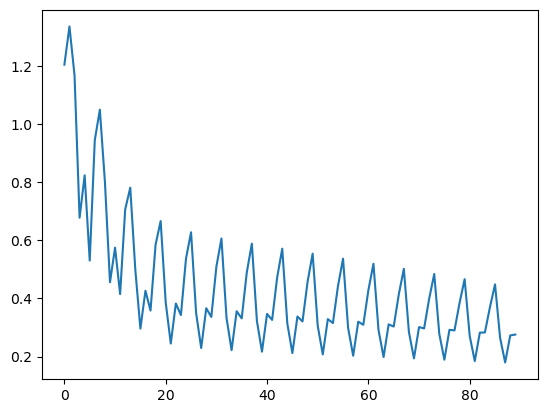

In [220]:
plt.plot(linear_losses)

In [242]:
class ANN(nn.Module):
    def __init__(self, insize=44, outsize=43):
        super(ANN, self).__init__()
        # set hyperparameters
        n_neuron       = 64
        model_num      = 1
        N_layers       = 2 # number of hidden layers
        
        self.layers = torch.nn.Sequential(torch.nn.Linear(insize, n_neuron), nn.ReLU())
        for i in range(N_layers):
            self.layers.append(torch.nn.Linear(n_neuron, n_neuron))
            self.layers.append(nn.ReLU())
        self.layers.append(torch.nn.Linear(n_neuron, outsize))
    
    def forward(self, x):
        return(self.layers(x))

In [243]:
ann = ANN().to(device)
ann

ANN(
  (layers): Sequential(
    (0): Linear(in_features=44, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=43, bias=True)
  )
)

In [244]:
ann, losses = train_model(ann, num_epochs=20, learning_rate=0.0005, minibatch_size=32)

Epoch Number 20, loss: 1.066576361656189, epoch time: 0.012201539675394694         

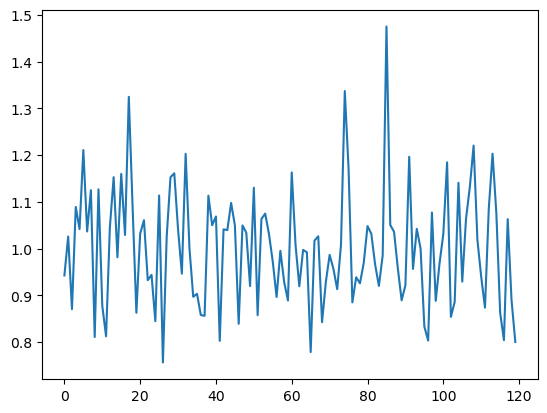

In [245]:
plt.plot(losses)

In [ ]:
import

In [246]:
ann2 = torch.load(os.path.join(baseDir, 'ANN_baseline.pt'))

In [248]:
torch.save(ann2.state_dict(), os.path.join(baseDir, 'ANN_baseline.pt'))

In [308]:
ann2

ANN(
  (layers): Sequential(
    (0): Linear(in_features=44, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=43, bias=True)
  )
)

### Get comparative quantitative metrics

In [370]:
ann.eval()
VED.eval()
linear_model.eval()
torch.no_grad()

In [298]:
def get_item(ds, index, as_numpy=True):
    assert index < ds.time.size * ds.ncol.size, "Index is outside of range"
    t, col = index // ds.ncol.size, index % ds.ncol.size
    x = ds.isel(time=t, ncol=[col])
    if(as_numpy):
        x = x.to_stacked_array("v", sample_dims=["ncol"]).values.reshape(-1)
    return(x)

In [396]:
def rec_data(ds, i):
    data = get_item(ds, i)
    norm = d * ds_sigma + ds_mu
    return(norm[:model_params['data_dims']], norm[-model_params['label_dims']:])

In [379]:
ds_mu[:44].shape

(44,)

In [388]:
def reconstruct(x, model=VED):
    # x is input to model, here we take model output
    with torch.no_grad():
        model.eval()
        Omu, Osigma = model(x)
        norm = Omu.cpu().numpy() * ds_sigma + ds_mu
        X_rec, Y_rec = norm[:model_params['data_dims']], norm[-model_params['label_dims']:]
    return(X_rec, Y_rec)

In [371]:
X_test = torch.tensor(X_test_np, device=device, dtype=torch.float32)
Y_test = torch.tensor(Y_test_np, device=device, dtype=torch.float32)

In [372]:
y_hat_linear = linear_model(X_test)

Omu, Osigma = VED(X_test)
Omu_x, Omu_y = Omu[:, :model_params['data_dims']], Omu[:, -model_params['label_dims']:]

y_hat_ann = ann(X_test)

In [500]:
Omut, Osigmat = VED(torch.tensor(X_train_np, device=device, dtype=torch.float32))
Omut_x, Omut_y = Omut[:, :model_params['data_dims']], Omut[:, -model_params['label_dims']:]
loss_fn(Omut_y, torch.tensor(Y_train_np, device=device, dtype=torch.float32))

tensor(0.9934, device='cuda:0', grad_fn=<MseLossBackward0>)

In [373]:
print(Omu_y.shape)
print(y_hat_ann.shape)
print(y_hat_linear.shape)

torch.Size([5824, 43])
torch.Size([5824, 43])
torch.Size([5824, 43])


In [374]:
loss_fn = torch.nn.MSELoss()

In [375]:
print(loss_fn(Omu_y, Y_test).item())
print(loss_fn(y_hat_ann, Y_test).item())
print(loss_fn(y_hat_linear, Y_test).item())

1.0871332883834839
0.30781424045562744
0.32242366671562195


#### Pearson Correlation Coefficient

In [436]:
ann_pred = y_hat_ann.detach().cpu().numpy()

In [440]:
lin_pred = y_hat_linear.detach().cpu().numpy()

In [441]:
VAE_pred = Omu_y.detach().cpu().numpy()

In [442]:
y_test = Y_test.detach().cpu().numpy()

In [475]:
pearson = []
p_value = []
n_samples = y_test.shape[0]
for i in range(n_samples):
    p = scipy.stats.pearsonr(lin_pred[i, :], y_test[i, :])
    pearson.append(p.statistic)
    p_value.append(p.pvalue)

In [477]:
np.array(pearson).mean()

0.634269923411181

In [461]:
scipy.stats.pearsonr(VAE_pred[0, :], y_test[0, :])

PearsonRResult(statistic=-0.16334652898947336, pvalue=0.2952741205399182)

#### R Squared

In [480]:
import sklearn
from sklearn.metrics import r2_score

In [493]:
y_test[i, :]

array([ 1.4302472  ,  1.2863814  ,  1.3021668  ,  0.06141682 ,
       -0.46244755 ,  0.57365024 ,  0.3922754  ,  0.30153286 ,
        0.092361465,  0.020946665,  0.7177695  ,  1.2989635  ,
        1.9787732  ,  2.1510336  ,  2.1998198  ,  2.3041623  ,
        2.381327   ,  2.4909809  ,  2.4497876  ,  2.2337713  ,
        0.726481   , -0.030214325, -0.17461537 , -2.1639826  ,
       -1.3972671  ,  1.4328887  ,  1.7710892  ,  1.8784299  ,
        1.9274334  ,  1.9399545  ,  1.7848707  ,  1.6341975  ,
        1.5465175  ,  1.5504289  ,  1.6000473  ,  1.5511932  ,
        1.4962897  ,  1.4529986  ,  1.4822464  ,  1.5990939  ,
        1.0229295  ,  1.9224879  , -0.16554937 ], dtype=float32)

In [485]:
r_ann = []
r_lin = []
r_ved = []
n_samples = y_test.shape[0]
for i in range(n_samples):
    r2 = r2_score(y_test[i, :], ann_pred[i,:])
    r_ann.append(r2)
    
    r2 = r2_score(y_test[i, :], lin_pred[i,:])
    r_lin.append(r2)
    
    r2 = r2_score(y_test[i, :], VAE_pred[i,:])
    r_ved.append(r2)

In [501]:
np.array(r_ann).mean()

0.38302059129718075

In [502]:
np.array(r_lin).mean()

0.3862288358081667

In [499]:
np.array(r_ved).mean()

-0.746037276980372

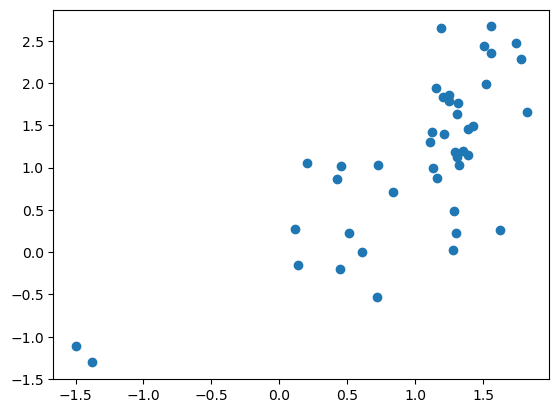

In [478]:
plt.scatter(lin_pred[10, :], y_test[10, :])

In [394]:
i = 100

In [395]:
x, y = test_dataset[i]

In [390]:
xhat, yhat = reconstruct(x)

In [399]:
xhat

array([1.2826589277e-06, 1.5178992718e-06, 1.5634604540e-06,
       1.5720838337e-06, 5.7363372656e-06, 4.0067884641e-05,
       1.0111184786e-04, 2.0559515975e-04, 5.6684708005e-04,
       9.7640792585e-04, 1.9531551060e-03, 2.3551740070e-03,
       3.6000046211e-03, 4.1398173303e-03, 6.0673302501e-03,
       6.8345615797e-03, 8.1538038806e-03, 8.9763244100e-03,
       1.0035100702e-02, 1.0676174041e-02, 2.5488725514e+02,
       2.3937358274e+02, 2.1918126633e+02, 2.0439217373e+02,
       2.0364438131e+02, 2.1791741254e+02, 2.2636523317e+02,
       2.3472465035e+02, 2.4463400588e+02, 2.5188702028e+02,
       2.6031938808e+02, 2.6671846737e+02, 2.7205686373e+02,
       2.7571196373e+02, 2.7944585160e+02, 2.8171372896e+02,
       2.8449915278e+02, 2.8600145801e+02, 2.8918690959e+02,
       2.9247749274e+02, 3.9003779110e+02, 8.2049676819e+01,
       2.0250779019e+01, 1.0011560100e+05])

In [397]:
xr, yr = rec_data(test, i)

In [398]:
xr

array([1.4767172620e-06, 1.4563057819e-06, 1.2516443765e-06,
       1.3019872939e-06, 7.1399913174e-06, 4.1949133440e-05,
       7.8177469720e-05, 1.7026678162e-04, 4.2653507591e-04,
       6.6298753022e-04, 1.4485991936e-03, 2.2924355266e-03,
       3.6138381785e-03, 4.6914109248e-03, 5.7216560020e-03,
       6.6995649689e-03, 7.4933231529e-03, 8.1505354607e-03,
       9.3942189140e-03, 9.9667901151e-03, 2.5768919982e+02,
       2.4525746306e+02, 2.2332405038e+02, 2.0467090108e+02,
       2.0574089874e+02, 2.1900580675e+02, 2.2637026454e+02,
       2.3393729067e+02, 2.4506338999e+02, 2.5203580602e+02,
       2.6093561803e+02, 2.6593819764e+02, 2.7155618346e+02,
       2.7402344894e+02, 2.7777763156e+02, 2.7939114772e+02,
       2.8228362587e+02, 2.8396752112e+02, 2.8635308622e+02,
       2.8975268292e+02, 4.6065164224e+02, 5.9731368839e+01,
       6.6384268047e+00, 1.0080204242e+05])

In [324]:
y_hat_linear[10, 0:5]

tensor([0.2035, 0.4263, 0.4545, 0.6083, 0.4427], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [ ]:
x, y = dataset[i]

In [ ]:
Omu_x, Omu_y = Omu[:model_params['data_dims']], Omu[-model_params['label_dims']:]

In [ ]:
Omu[model_params['data_dims']:] == Omu[-model_params['label_dims']:]

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True], device='cuda:0')

In [426]:
p = iter(VED.parameters())

In [427]:
next(p)

Parameter containing:
tensor([[ 0.0058,  0.0646,  0.0891,  ...,  0.0697, -0.1023,  0.0339],
        [-0.0370, -0.0951,  0.1182,  ..., -0.0619, -0.1420, -0.0477],
        [ 0.0268, -0.0701, -0.1082,  ..., -0.0372, -0.0287,  0.0948],
        ...,
        [ 0.1141, -0.0395,  0.0806,  ..., -0.0568,  0.0778,  0.0794],
        [-0.0485,  0.0729,  0.0409,  ...,  0.0344,  0.0185, -0.1222],
        [-0.0448, -0.0168,  0.0519,  ..., -0.0507, -0.0729, -0.0580]],
       device='cuda:0', requires_grad=True)

### Latent Space Analysis

In [416]:
import sklearn
from sklearn.decomposition import PCA
class LatentInterpreter():
    def __init__(self, encoder, dataset):
        self.model = encoder
        self.dataset = dataset
        self.embeddings = {}
        self.pca = 0

    def calculate_embeddings(self, num_samples=500, start_index=0):
        self.embeddings = {}
        with torch.no_grad():
            model.eval()
            for i in range(start_index, start_index + num_samples):
                x, y = self.dataset[i]
                z = self.model(x).to('cpu').numpy()
                self.embeddings[i] = z
    def embeddings_as_tensor(self):
        return(torch.tensor(np.vstack(list(self.embeddings.values())), dtype=torch.float32))
                
    def set_embeddings(self, embeddings):
        assert type(embeddings) == dict, "Expected a dictionary format"
        self.embeddings = embeddings
    
    def latentPCA(self):
        if(not len(self.embeddings)): # if have not saved embeddings
            self.get_embeddings()
        
        pca = PCA(n_components=2)
        pca.fit(list(self.embeddings.values()))
        self.pca = pca
    
    def plot_variable_PC(self, ds, variable, cmap='plasma', title='', level=59, savefig=False):
        # assume data to be segmented in some form to highlight/ visualize some specific trend
        # components is ndarray shape (n_components, n_features)
        if(not self.pca):
            self.latentPCA()
        
        if not title:
            title = f'{var} plotted across latent, level {selected_levels[8]}'
        pc1 = torch.tensor(self.pca.components_[0, :], dtype=torch.float32)
        pc2 = torch.tensor(self.pca.components_[1, :], dtype=torch.float32)
        
        z = self.embeddings_as_tensor()
        x_values = torch.matmul(z, pc1)
        y_values = torch.matmul(z, pc2)
        c_values = []
        
        for index in self.embeddings.keys():
            c_values.append(get_item_value(ds, index, variable, level_value=level).item())
        plt.scatter(x_values, y_values, c=c_values, cmap=cmap)
        plt.colorbar(label=variable)
        plt.xlabel("First Principal Component")
        plt.ylabel("Second Principal Component")
        plt.title(title)
        if(savefig):
            print("saving")
            plt.savefig('latent_space_ED')
        plt.show()
    
    def estimate_pz(self, dims, bins):
        z = self.embeddings_as_tensor()
        for dim in dims:
            plt.hist(z[:, dim], bins=bins, density=True)
            plt.title(f"Dimension {dim} of Latent Space")
            plt.xlabel("Value of z")
            plt.ylabel("Probability Density Estimate")
            plt.show()

In [77]:
len(dataset)

17520

In [417]:
%%time
interp = LatentInterpreter(VED.encoder, train_dataset)
embeddings = interp.calculate_embeddings(500, start_index=1650)
interp.latentPCA()

CPU times: user 21.5 s, sys: 102 ms, total: 21.6 s
Wall time: 21.6 s


In [413]:
def get_item_value(ds, index, variable, level_value=59):
    # t * ds.ncol.size + col == i
    # given an index, wrap around (time x ncol) grid selecting specific variable
    # converting linear indexing into structured
    
    # if level variable can specify which level; default is surface but doesn't matter
    if(level_value not in selected_levels):
        print("Level value not in selected values, please choose again")
    else:
        levs = list(selected_levels).index(level_value)     
    ds = ds.sel(lev=ds.lev[levs])[variable]
    
    assert index < ds.time.size * ds.ncol.size, "Index is outside of range"
    t, col = index // ds.ncol.size, index % ds.ncol.size
    return(ds.isel(time=t, ncol=col))

In [76]:
y.shape

torch.Size([43])

In [414]:
selected_levels

array([ 4,  8, 12, 16, 20, 24, 26, 28, 31, 33, 36, 38, 41, 43, 46, 48, 51,
       53, 56, 59], dtype=int32)

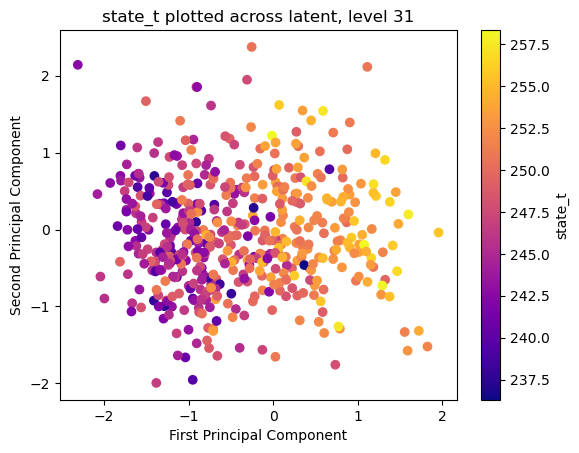

In [420]:
var = 'state_t'
interp.plot_variable_PC(ds, var, level = 33, savefig=False)

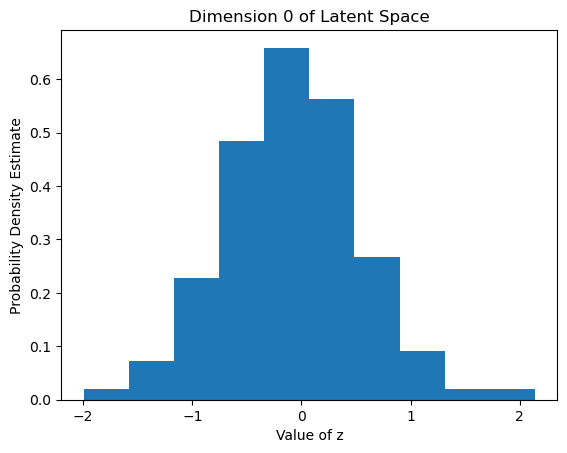

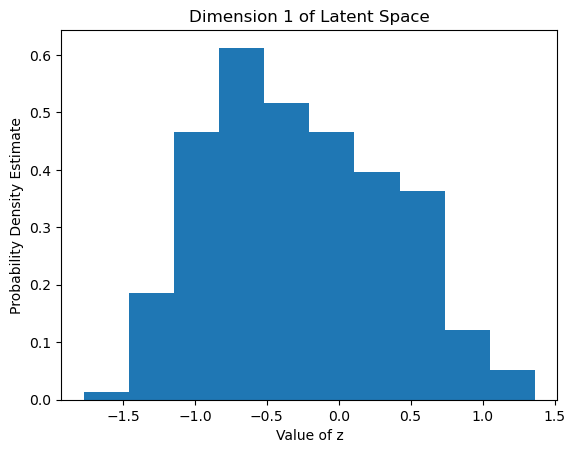

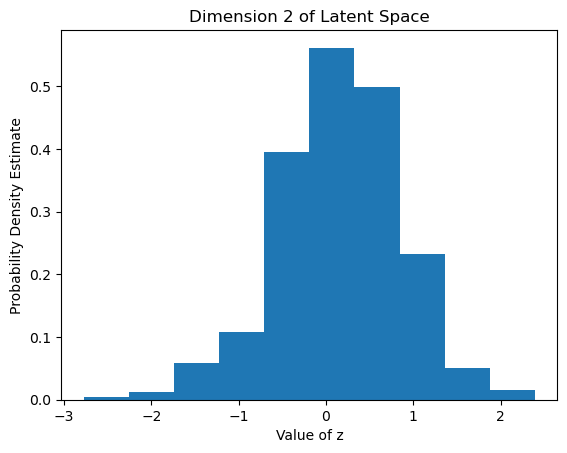

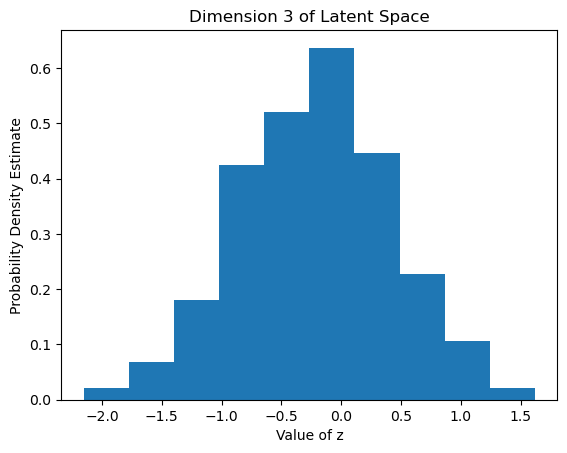

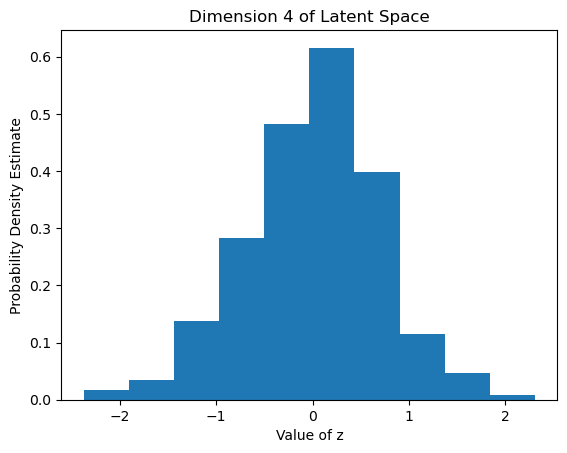

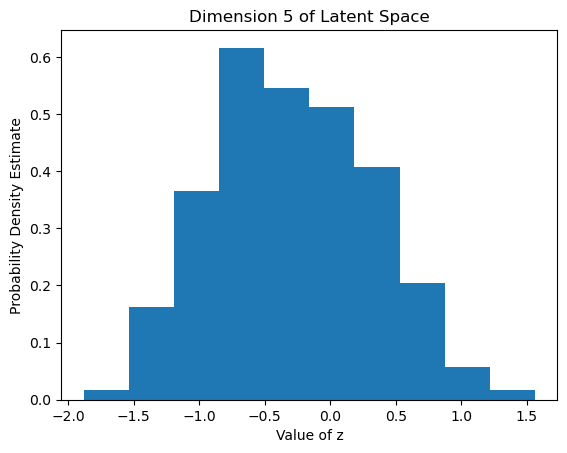

In [421]:
interp.estimate_pz([0, 1, 2, 3, 4, 5], 10)

## Latent Traversal

## OLD CODE

In [ ]:
batch_sizes = [1, 4, 8, 32, 64, 256, 1000, 2000]
times = []
for size in batch_sizes:
    start = time.time()
    dataloader = DataLoader(dataset, batch_size=size, shuffle=False)
    X, Y = next(iter(dataloader))
    times.append(time.time() - start)
plt.plot(batch_sizes, times) # pretty much linear with batch size, so does not really matter

In [90]:
def trainer(model, dataloader, save_params, train_params):

    # Training parameters
    if train_params['optimizer'] == 'adam':
        opt = torch.optim.Adam(model.parameters(), lr=train_params['lr'], weight_decay=train_params['weight_decay'])
    elif train_params['optimizer'] == 'sgd':
        opt = torch.optim.SGD(model.parameters(), lr=train_params['lr'], weight_decay=train_params['weight_decay'])
    else:
        raise ValueError('Unknown optimizer')
    batches_per_epoch = len(dataloader)
    path = os.path.join(save_params['model_path'], save_params['name']) + save_params['filetype'] # checkpoint 
    text = 'Training '
    start = time.time()
    last = start
    last_timed = start

    losses = []
    KL_div = []
    for epoch in range(train_params['epochs']):
        for batch_num, (x,y) in enumerate(dataloader):
            now = time.time()
            if batch_num == 0 or batch_num == batches_per_epoch - 1 or now - last > 0.5: # print time status updates
                last = now
                perc = (epoch * batches_per_epoch + batch_num + 1) / (train_params['epochs'] * batches_per_epoch)
                inv_perc = (train_params['epochs'] * batches_per_epoch) / (epoch * batches_per_epoch + batch_num + 0.1)
                sys.stdout.write("\r%s[%.1f %%] - %d / %d (%d / %d) - %.1fs [TBD: %.1fs]" %
                                 (text, 100 * perc, epoch + 1, train_params['epochs'], batch_num + 1, batches_per_epoch,
                                  now - start, (now - start) * (inv_perc - 1)))
                sys.stdout.flush()
            if save_params['save'] and now - last_timed > save_params['save_interval']:
                torch.save(model.state_dict(), path)
                last_timed = now
            
            O_real = torch.cat([x, y], 1).to(model.device) # actual output desired 
            O_hat, O_std = model(x)

            # loss = ((y - y_hat) ** 2).sum() / self.label_dims + self.beta * self.encoder.kl / self.latent_dims
            rec_loss = 0.5 * (O_real - O_hat) ** 2 #+ torch.log(O_std)
            loss = rec_loss.mean() + model.beta * model.encoder.kl
            #loss = (0.5 * (y - y_mean) ** 2 / y_std + torch.log(y_std)).mean() + self.beta * self.encoder.kl

            #torch.clip(loss, min=-1e5, max=1e5).backward() # backpropagate loss
            KL_div.append(model.encoder.kl.item())
            losses.append(loss.item()) 
            loss.backward()
            opt.step()
            opt.zero_grad() # VERY IMPORTANT! Reset gradients. 

    print('Last-epoch loss: %.2f' % sum(losses[-batches_per_epoch:-1]))
    print('Finished Training')

    return(model, {"losses" : losses, "KL" : KL_div})

In [ ]:
model, info = trainer(VED, dataloader, save_params, train_params)

In [ ]:
toy_vars = 'state_q0001 state_t cam_out_PRECC'.split()
toy = load_vars_xarray(toy_vars[:2], [toy_vars[2]], downsample=True, chunks = True)
selected_levels = np.append(np.linspace(4, 24, 6), np.linspace(26, 59, 14)).astype(np.int32)
toy = toy.isel(lev=selected_levels)
toy = toy.isel(time = slice(0, 365), ncol=slice(0, 16))
with ProgressBar():
    toy.load()



def select_region(condition):
    # assumes condition is a lambda function taking in a lat and lon
    # returns the indices for which this is true
    lat, lon = ds.lat.values, ds.lon.values
    latlon = pd.DataFrame({"lat" : lat, "lon": lon})
    return(list(latlon[latlon.apply(condition, axis=1)].index)) # the indices of the matching latlons

def split_ds_by_area(ds, condition):
    match = select_region(condition)
    unmatch = select_region(lambda row : not condition(row))
    return(ds.isel(ncol=match), ds.isel(ncol=unmatch))

train, test = split_ds_by_area(ds, lambda row : abs(row.lat) < 45)
train